# Example to demonstrate how to use queues
https://www.tensorflow.org/programmers_guide/threading_and_queues

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

import numpy as np
import tensorflow as tf

N_SAMPLES = 1000
NUM_THREADS = 4
# Generating some simple data
# create 1000 random samples, each is a 1D array from the normal distribution (10, 1)
data = 10 * np.random.randn(N_SAMPLES, 4) + 1 
# create 1000 random labels of 0 and 1
target = np.random.randint(0, 2, size=N_SAMPLES) 

In [2]:
queue = tf.FIFOQueue(capacity=50, dtypes=[tf.float32, tf.int32], shapes=[[4], []])

enqueue_op = queue.enqueue_many([data, target])
data_sample, label_sample = queue.dequeue()

# create ops that do something with data_sample and label_sample

In [3]:
# create NUM_THREADS to do enqueue
qr = tf.train.QueueRunner(queue, [enqueue_op] * NUM_THREADS)
with tf.Session() as sess:
	# create a coordinator, launch the queue runner threads.
	coord = tf.train.Coordinator()
	enqueue_threads = qr.create_threads(sess, coord=coord, start=True)
	try:
		for step in range(100): # do to 100 iterations
			if coord.should_stop():
				break
			data_batch, label_batch = sess.run([data_sample, label_sample])
			print(data_batch)
			print(label_batch)
	except Exception as e:
		coord.request_stop(e)
	finally:
		coord.request_stop()
		coord.join(enqueue_threads)

[ 13.85189438 -13.60285759  -6.34741259   4.7430625 ]
0
[ 11.31130981  -1.58416128  -8.42000103  -3.76328444]
1
[-11.7549448    8.35333347  -3.97752237  -3.3406148 ]
0
[  9.75626087  26.10517693   2.7928977   27.0292511 ]
1
[-11.74189854  -0.3326332   -0.45327029  13.2197094 ]
0
[ 10.71866131  20.70821953  12.44595528  10.22998524]
1
[  8.82983398  -1.73809588  -6.40705013 -18.25826836]
0
[  7.98746824  -3.45401192  12.25248146 -11.17381096]
1
[ -4.34883785 -11.21769238  -1.30738664   1.17836213]
1
[ 32.60272217  -5.39345312   3.2701962   12.46237755]
1
[-15.15381527  11.22998142   5.47279167   2.38790131]
1
[ -3.35461569   1.40161884  -6.35100889 -11.71273613]
0
[ -2.35952735  19.21423149  -6.88031244   4.12647152]
0
[  3.72816563  17.26899529  -6.51411152  -8.66740417]
0
[ 15.52161217  -4.1729269    7.92958403  -8.09450722]
1
[  7.75641203 -17.26208496  -1.4405663    9.23808098]
0
[-3.55079341 -2.68986583 -5.43038988 -1.67907536]
1
[ 12.09705448  -0.67727846   8.22484207   8.44118214

# Examples to demonstrate how to write an image file to a TFRecord
http://www.machinelearninguru.com/deep_learning/tensorflow/basics/tfrecord/tfrecord.html

1
[322 403   3]


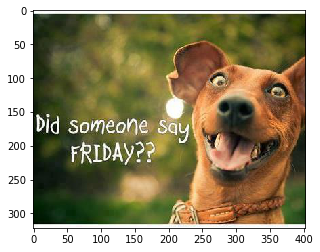

In [4]:
import sys
sys.path.append('..')

from PIL import Image
import matplotlib.pyplot as plt

# image supposed to have shape: 480 x 640 x 3 = 921600
IMAGE_PATH = 'examples/data/'

def _int64_feature(value):
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def _bytes_feature(value):
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def get_image_binary(filename):
    """ You can read in the image using tensorflow too, but it's a drag
        since you have to create graphs. It's much easier using Pillow and NumPy
    """
    image = Image.open(filename)
    image = np.asarray(image, np.uint8)
    shape = np.array(image.shape, np.int32)
    return shape.tobytes(), image.tobytes() # convert image to raw data bytes in the array.

def write_to_tfrecord(label, shape, binary_image, tfrecord_file):
    """ This example is to write a sample to TFRecord file. If you want to write
    more samples, just use a loop.
    """
    writer = tf.python_io.TFRecordWriter(tfrecord_file)
    # write label, shape, and image content to the TFRecord file
    example = tf.train.Example(features=tf.train.Features(feature={
                'label': _int64_feature(label),
                'shape': _bytes_feature(shape),
                'image': _bytes_feature(binary_image)
                }))
    writer.write(example.SerializeToString())
    writer.close()

def write_tfrecord(label, image_file, tfrecord_file):
    shape, binary_image = get_image_binary(image_file)
    write_to_tfrecord(label, shape, binary_image, tfrecord_file)

def read_from_tfrecord(filenames):
    tfrecord_file_queue = tf.train.string_input_producer(filenames, name='queue')
    reader = tf.TFRecordReader()
    _, tfrecord_serialized = reader.read(tfrecord_file_queue)

    # label and image are stored as bytes but could be stored as 
    # int64 or float64 values in a serialized tf.Example protobuf.
    tfrecord_features = tf.parse_single_example(tfrecord_serialized,
                        features={
                            'label': tf.FixedLenFeature([], tf.int64),
                            'shape': tf.FixedLenFeature([], tf.string),
                            'image': tf.FixedLenFeature([], tf.string),
                        }, name='features')
    # image was saved as uint8, so we have to decode as uint8.
    image = tf.decode_raw(tfrecord_features['image'], tf.uint8)
    shape = tf.decode_raw(tfrecord_features['shape'], tf.int32)
    # the image tensor is flattened out, so we have to reconstruct the shape
    image = tf.reshape(image, shape)
    label = tfrecord_features['label']
    return label, shape, image

def read_tfrecord(tfrecord_file):
    label, shape, image = read_from_tfrecord([tfrecord_file])

    with tf.Session() as sess:
        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(coord=coord)
        label, image, shape = sess.run([label, image, shape])
        coord.request_stop()
        coord.join(threads)
    print(label)
    print(shape)
    plt.imshow(image)
    plt.show() 

def main():
    # assume the image has the label Chihuahua, which corresponds to class number 1
    label = 1 
    image_file = IMAGE_PATH + 'friday.jpg'
    tfrecord_file = IMAGE_PATH + 'friday.tfrecord'
    write_tfrecord(label, image_file, tfrecord_file)
    read_tfrecord(tfrecord_file)

if __name__ == '__main__':
    main()